# Towards SAT Solving for Graph Aggregation
This notebook is based on the notebook for the course on *Computational Social Choice*, demonstrating how to use SAT-solving technology to reason about voting rules, prepared by [Ulle Endriss](https://staff.science.uva.nl/u.endriss/), ILLC, University of Amsterdam (November 2023).

This notebook is part of the implementation of a project extending SAT solving to the graph aggregation domain, as set up by [Endriss & Grandi, 2018](https://dl.acm.org/doi/abs/10.1145/3184558.3186231).

## System Requirements
You need to be able to run [Jupyter Notebooks](https://realpython.com/jupyter-notebook-introduction/) for Python 3 and you need to have the [PySAT](https://pysathq.github.io/) toolkit [installed](https://pysathq.github.io/installation/) on your machine. 

## Using this Notebook
The recommended way of using this notebook is to first restart the kernel and then run the entire notebook cell by cell. With the exception of two cells near the end of the notebook, this should not generate any error messages. Then go to any of the cells labelled **"Try it!"** and see what happens when you make changes to those cells and run them again.

Beware that some of the code is only explained on the slides and not here. Note that I followed to a 'minimalist' coding philosophy: trying to write as little code as possible and trying to make that code as easy to understand as possible. So this is neither maximally efficient (but easily fast enough for our present needs) nor maximally robust (but it works fine when used as intended).

## Imports
We first import some extra functionality from standard Python modules, so we can easily (a) compute the factorial of a given number, (b) work with the list of all permutations of a given list, and (c) randomly shuffle a given list.

In [1]:
from math import factorial
from itertools import permutations
from random import shuffle

## SAT Solving
We want to use SAT-solving technology to reason about voting rules. In this section, we provide the methods required to make this technology available to us. Specifically, we define methods to check whether a given formula is satisfiable, to enumerate all models of a satisfiable formula, and to compute a minimally unsatisfiable subset (MUS) of an unsatisfiable set of clauses. Our methods are simple wrappers around more sophisticated versions of the same methods provided by PySAT. Note that none of this is specific to our intended application to social choice theory. 

A *SAT solver* is a program that can determine whether a given formula of propositional logic is *satisfiable*. Recall that a formula $\varphi$ is satisfiable if there exists an assignment of truth values to the propositional variables occurring in $\varphi$ for which $\varphi$ evaluates to *true*. Formulas must be provided in *conjunctive normal form* (CNF). Recall that a formula in CNF is a conjunction ('and') of *clauses*, with a clause being a disjunction ('or') of *literals*. A literal, in turn, is either a propositional variable or the negation of a propositional variable. 

In our code, we use positive integers to represent positive literals (i.e., propositional variables), negative integers to represent negative literals (i.e., negations of propositional variables), lists of integers to represent clauses, and lists of such lists to represent formulas in CNF. Thus, for example, the list `[[1,-3,2],[-2]]` represents the formula $(p_1 \lor \neg p_3 \lor p_2) \land (\neg p_2)$. This is known as the DIMACS format.

We first import the required functionality from PySAT. The first import makes available the solver Glucose 3.0 (any of the other solvers should work just as well). The second makes available a module for working with weighted formulas in CNF, which is required for the implementation of the MUS extractor provided by means of the third import.

In [2]:
from pysat.solvers import Glucose3
from pysat.formula import WCNF
from pysat.examples.musx import MUSX

The method `solve()` implemented below offers easy access to the corresponding method of our chosen SAT solver. If you apply this method to a formula $\varphi$ in CNF, it will return the string `UNSATISFIABLE` in case $\varphi$ is unsatisfiable, and otherwise a *model* that satisfies $\varphi$. Any such a model is presented in the form of a list of positive and negative integers, indicating which propositional variables must be set to *true* and which must be set to *false*.

In [3]:
def solve(cnf):
    solver = Glucose3()
    for clause in cnf: solver.add_clause(clause)
    if solver.solve():
        return solver.get_model()
    else:
        return('UNSATISFIABLE')

**Try it!** You can change the CNF formula (i.e., the list of lists of integers) in the example below to test different formulas for their satisfiability.

In [4]:
solve([[1,2], [1,-2], [-1,2], [-1,-2]])

'UNSATISFIABLE'

The method `enumModels()` can be used to enumerate all satisfying models of a given formula in CNF. Keep in mind that this is a demanding operation and that the number of models can be huge. Note that the object returned by `enumModels()` is an iterator (not a list). A simple way of inspecting it is to use the `list()` method on the object returned by `enumModels()`.

In [5]:
def enumModels(cnf):
    solver = Glucose3()
    for clause in cnf: solver.add_clause(clause)
    return solver.enum_models()

**Try it!**

In [6]:
models = enumModels([[-1,-2,3], [2], [-3,1]])
print(list(models))

[[-1, 2, -3], [1, 2, 3]]


The method `getMUS()` can be used to compute an MUS for a given formula in CNF (which should be unsatisfiable). Note that a given formula might have more than one MUS, and `getMUS()` does not necessarily return the smallest MUS (because computing a cardinality-minimal MUS is a much more demanding operation).

In [7]:
def getMUS(cnf):
    wcnf = WCNF()
    for clause in cnf: wcnf.append(clause, 1)
    mus = MUSX(wcnf,verbosity=0).compute()
    return list(cnf[i-1] for i in mus)

**Try it!** The list we obtain represents an unsatisfiable set of clauses that becomes satisfiable as soon as we remove even a single clause from it.

In [8]:
getMUS([[-1,2], [1], [-3,4], [-2], [3,-4]])

[[-1, 2], [1], [-2]]

## Preferences and Profiles
In this section, we set up everything we need to represent (a) voters, (b) alternatives, (c) preferences of a single voter over the alternatives, and (d) profiles bundling the preferences of all voters. Observe that $n$ voters and $m$ alternatives, there are $m!$ possible preferences and $m!^n$ possible profiles.

We first fix `n`, the number of voters, and `m`, the number of alternatives. For much of what we are going to do, we shall assume `n = 2` and `m = 3`. Keep in mind that the number of objects we are dealing with grows exponentially in `n` and superexponentially in `m`, so things are unlikely to work well (or at all) for even moderately larger numbers.

In [9]:
from config import config

In [10]:
# config, utils, axioms, properties, literals
from config import config
from utils import *
from axioms import *
from properties import *

In [11]:
graphCNF(get_graph(1, config.v))

[(1,), (-2,), (-3,), (-4,), (-5,), (-6,), (-7,), (-8,), (-9,)]

In [12]:
cnfCompleteness()

[(2, 4), (3, 7), (4, 2), (6, 8), (7, 3), (8, 6)]

In [13]:
prop_fns = [cnfReflexivity, cnfTransitivity, cnfCompleteness]
graphs = generate_graph_subsets(prop_fns)

# graphs = generate_graph_subsets([cnfIrreflexivity, cnfConnectedness, cnfTransitivity, cnfCompleteness])
config.update_graphs(graphs)

Updating config.graphs
Updating config.g := 13


[(0, 0), (0, 1), (0, 2), (1, 1), (1, 2), (2, 2)]


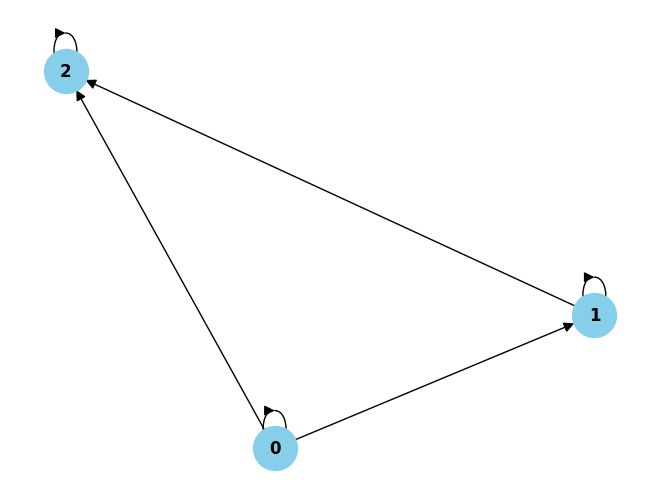

[(0, 0), (0, 2), (1, 0), (1, 1), (1, 2), (2, 2)]


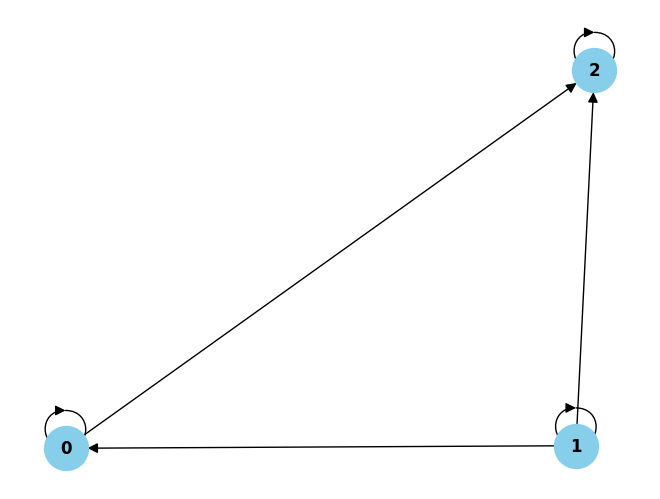

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 2)]


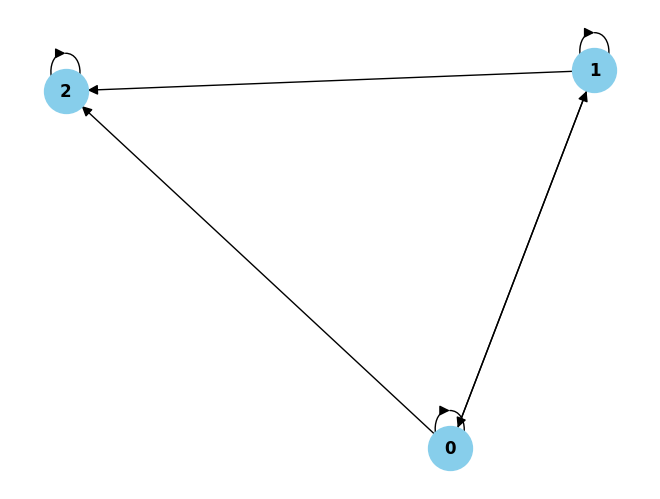

[(0, 0), (1, 0), (1, 1), (1, 2), (2, 0), (2, 2)]


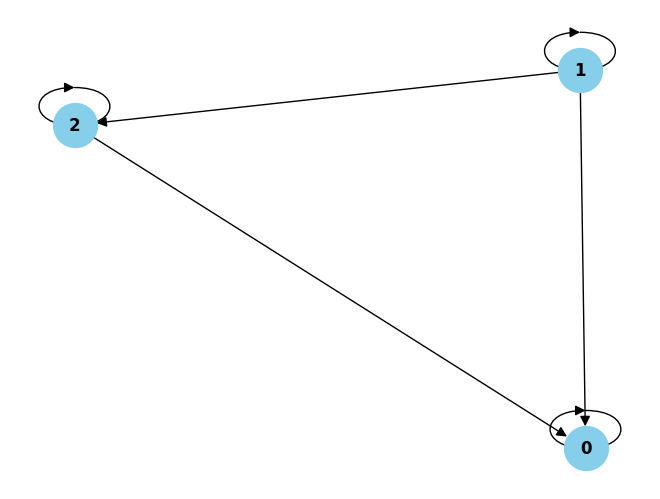

[(0, 0), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 2)]


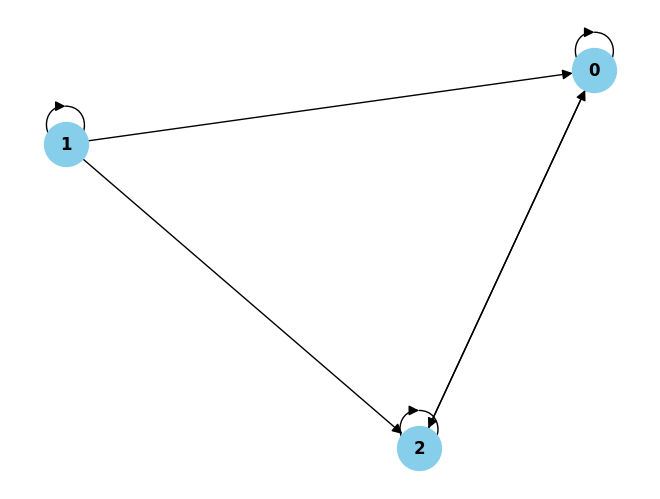

[(0, 0), (0, 1), (0, 2), (1, 1), (2, 1), (2, 2)]


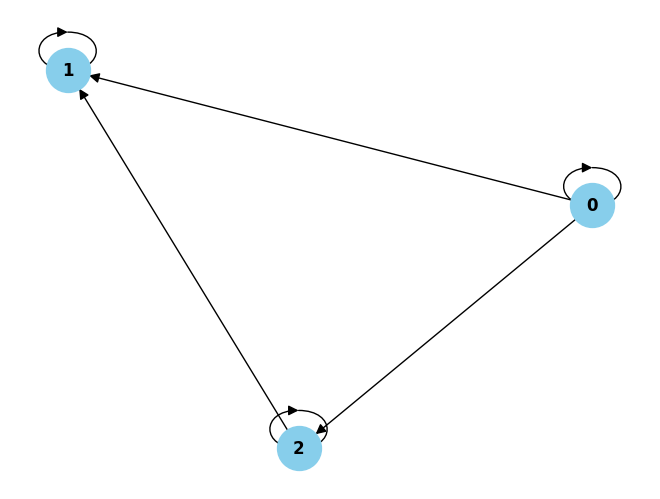

[(0, 0), (0, 1), (0, 2), (1, 1), (1, 2), (2, 1), (2, 2)]


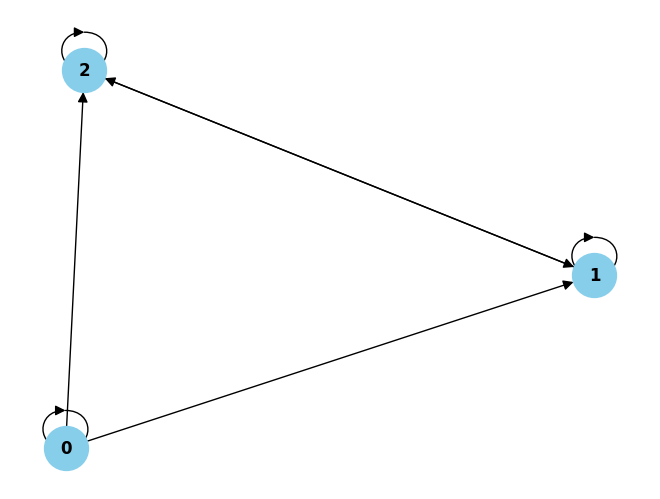

[(0, 0), (0, 1), (1, 1), (2, 0), (2, 1), (2, 2)]


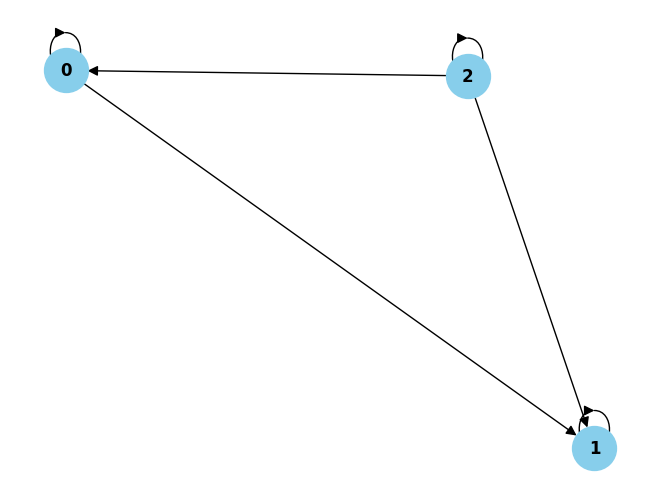

[(0, 0), (0, 1), (0, 2), (1, 1), (2, 0), (2, 1), (2, 2)]


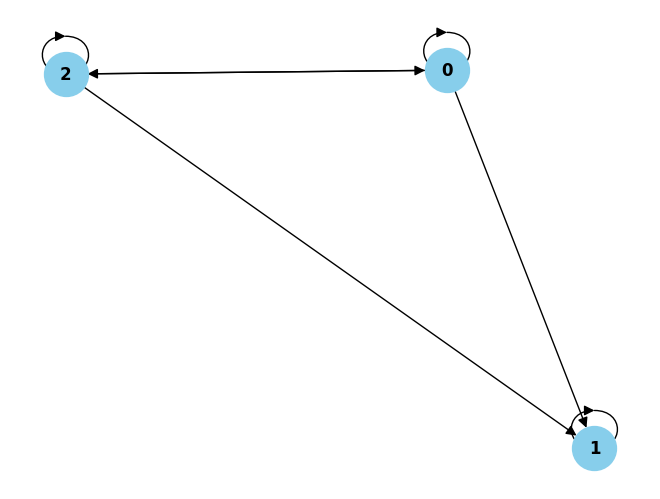

[(0, 0), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2)]


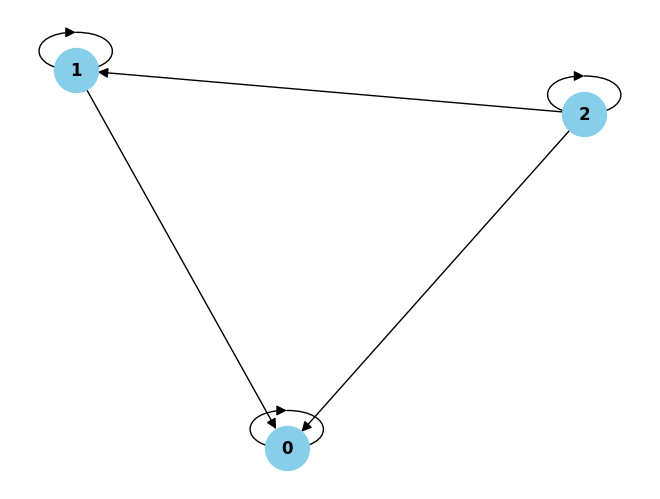

[(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2)]


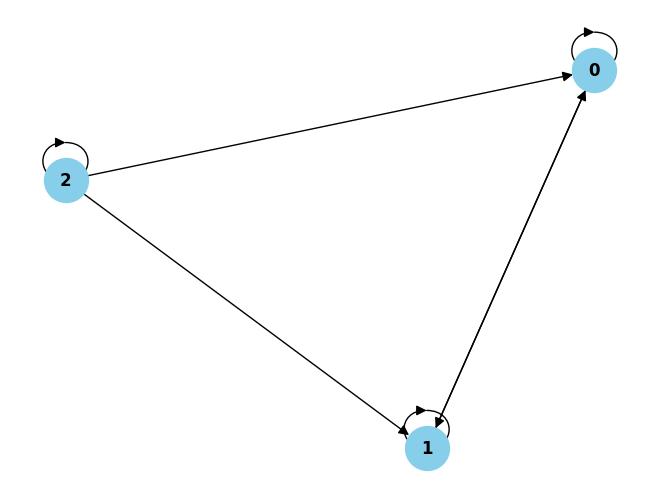

[(0, 0), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


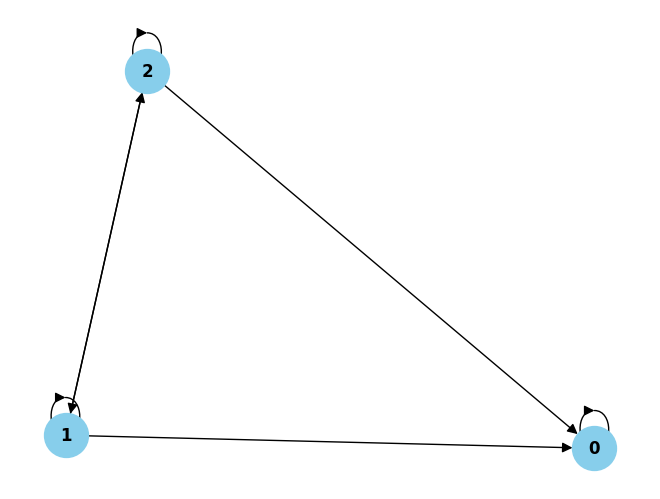

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


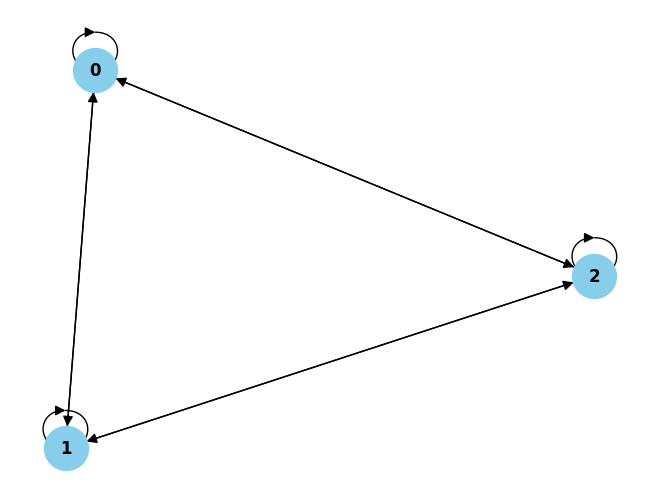

In [14]:
from plot import draw_labeled_graph
for graph in config.graphs:
    edges = get_graph(graph, config.v)
    print(edges)
    draw_labeled_graph(edges, config.v)


In [15]:
config.g

13

In [16]:
cr = cr_fn(prop_fns)
arrow_axioms = [iie, nondictatorship, unanimity, grounded, cr]
iie_cnf = iie()
nondict_cnf = nondictatorship()
unanim_cnf = unanimity()
ground_cnf = grounded()
cr_cnf = cr()

Expected clauses:  86882562


In [17]:

cnf = iie_cnf + nondict_cnf + unanim_cnf + ground_cnf + cr_cnf
print("Total clauses:", len(cnf))
solve(cnf)

Total clauses: 86990407


'UNSATISFIABLE'

In [18]:
# SANS IIE
cnf = nondict_cnf + unanim_cnf + ground_cnf + cr_cnf
print("Total clauses:", len(cnf))
sans_iie = enumModels(cnf)
print("EXISTING MODELS:", len(list(sans_iie)))

Total clauses: 107845
EXISTING MODELS: 0


In [19]:
# SANS NONDICT
cnf = iie_cnf + unanim_cnf + ground_cnf + cr_cnf
print("Total clauses:", len(cnf))
sans_nondict = enumModels(cnf)
print("EXISTING MODELS:", len(list(sans_nondict)))

Total clauses: 86990404
EXISTING MODELS: 0


In [20]:
# SANS UNANIMITY
cnf = iie_cnf + nondict_cnf + ground_cnf + cr_cnf
print("Total clauses:", len(cnf))
sans_unanimity = enumModels(cnf)
print("EXISTING MODELS:", len(list(sans_unanimity)))

Total clauses: 86974352
EXISTING MODELS: 0


In [21]:
# SANS GROUNDED
cnf = iie_cnf + nondict_cnf + unanim_cnf + cr_cnf
print("Total clauses:", len(cnf))
sans_grounded = enumModels(cnf)
print("EXISTING MODELS:", len(list(sans_grounded)))

Total clauses: 86977712
EXISTING MODELS: 0


In [22]:
# SANS COLLECTIVE RATIONALITY
cnf = iie_cnf + nondict_cnf + unanim_cnf + ground_cnf
print("Total clauses:", len(cnf))
sans_cr = enumModels(cnf)
print("EXISTING MODELS:", len(list(sans_cr)))

Total clauses: 86911315
EXISTING MODELS: 1


In [23]:
solutions = list(enumModels(cnf))

"""# prepare properties cnf
prop_cnf = []
for fn in prop_fns:
    prop_cnf += fn()

pp_cnf = [] # properties, repeated for each profile
# generate prof-prop clauses
for E in allProfiles():
    for clause in prop_cnf:
        try:
            pp_cnf.append(tuple([toLiteral(lit, E)[0] for lit in clause]))
        except TypeError as e:
            print(clause)
            print(e)

cr_sols = []
for i, sol in enumerate(solutions):
    
    cr_cnf = [(s,) for s in sol] + pp_cnf.copy()
    is_sat = solve(cr_cnf)

    if is_sat == 'UNSATISFIABLE':
        print(f"SOL {i}: NOT COLLECTIVELY RATIONAL")
    else:
        cr_sols.append(sol)
        print(f"SOL {i}: COLLECTIVELY RATIONAL")

print(f"{len(cr_sols)} TOTAL CR SOLUTIONS")"""

'# prepare properties cnf\nprop_cnf = []\nfor fn in prop_fns:\n    prop_cnf += fn()\n\npp_cnf = [] # properties, repeated for each profile\n# generate prof-prop clauses\nfor E in allProfiles():\n    for clause in prop_cnf:\n        try:\n            pp_cnf.append(tuple([toLiteral(lit, E)[0] for lit in clause]))\n        except TypeError as e:\n            print(clause)\n            print(e)\n\ncr_sols = []\nfor i, sol in enumerate(solutions):\n    \n    cr_cnf = [(s,) for s in sol] + pp_cnf.copy()\n    is_sat = solve(cr_cnf)\n\n    if is_sat == \'UNSATISFIABLE\':\n        print(f"SOL {i}: NOT COLLECTIVELY RATIONAL")\n    else:\n        cr_sols.append(sol)\n        print(f"SOL {i}: COLLECTIVELY RATIONAL")\n\nprint(f"{len(cr_sols)} TOTAL CR SOLUTIONS")'

In [24]:
#def colrec(sols, )

In [25]:
len(list(enumModels(cnf)))

1

It will be convenient to also represent preferences and profiles as integers (just think of some enumeration of all preferences and assign integers to them, starting with `0`, and similarly for profiles). The method below can be used to return the set of all such integers representing profiles (we happen to not require a corresponding method for preferences).

In [26]:
mus = getMUS(cnf)

from explain import Explain
ex = Explain(arrow_axioms)
ex(mus)

MemoryError: 